In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from scipy import integrate
import scipy as sc
from funcs import *
from scipy.integrate import odeint
np.set_printoptions(precision=3, suppress=True)
%matplotlib notebook
## Python 3.11.4

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["CMU"],
})

In [2]:
'''
DEFINE EXAMPLE FUNCTION
'''

def saddle_node_hyst(t, x, a):
    return (a+x-x**3)

tf = 10
dt = 0.01
t = np.arange(0, tf, dt)

new_step = int(tf/dt)
new_step

1000

C:\Users\javie\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


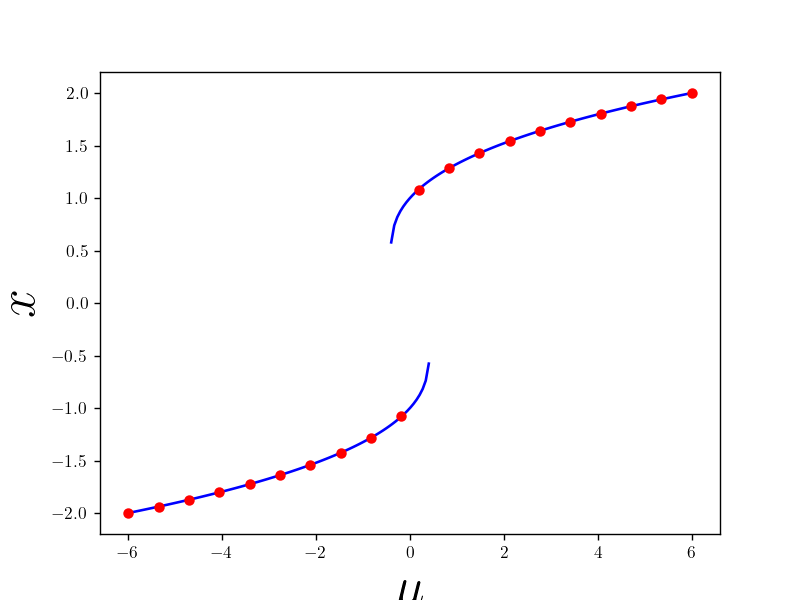

In [3]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Define the function for which equilibrium points are sought
def equation(x, a):
    return a + x - x**3

# Define a range of values for 'a'
a_values = np.linspace(-6, 0.4, 100)
a_values2 = np.linspace(6, -0.4, 100)

# Store equilibrium points for each 'a'
equilibrium_points = []
equilibrium_points2 = []

# Find equilibrium points for each 'a'
initial_guess = -2
initial_guess2 = 2
for a in a_values:
    # Use fsolve to find the roots of the equation
    equilibrium = fsolve(equation, x0=initial_guess, args=(a,), xtol=1e-10)
    equilibrium_points.append((a, equilibrium[0]))
    initial_guess = equilibrium[0]
    
for a in a_values2:
    # Use fsolve to find the roots of the equation
    equilibrium2 = fsolve(equation, x0=initial_guess2, args=(a,), xtol=1e-10)
    equilibrium_points2.append((a, equilibrium2[0]))
    initial_guess2 = equilibrium2[0]


# Plot the equilibrium points
x_eqs = [x_eq for a, x_eq in equilibrium_points]
x_eqs2 = [x_eq for a, x_eq in equilibrium_points2]

mu1 = [(a, x_eq) for a, x_eq in equilibrium_points[::10]]
mu2 = [(a, x_eq) for a, x_eq in equilibrium_points2[::10]]
mu = np.array(mu1 + mu2)

pts_eq = np.c_[mu[:, 1], np.array(mu1 + mu2)[:, 0]]
n_ics = pts_eq.shape[0]

plt.figure()
plt.plot(a_values, x_eqs, 'b')
plt.plot(a_values2, x_eqs2, 'b')
plt.plot(mu[:, 0], mu[:, 1], 'r.', markersize=10)
plt.xlabel('$\mu$', fontsize=30)
plt.ylabel('$x$', fontsize=30)
plt.show()

In [4]:
x0 = [np.zeros((t.size, 2)) for i in range(n_ics)]
x0_train = [0]

ic_idx = 0
for u in pts_eq[:, 1]:
    x_tot = sc.integrate.solve_ivp(saddle_node_hyst, [0, tf], x0_train, t_eval=t, args=[u])
    x0[ic_idx][:, 0] = x_tot.y[0].T
    x0[ic_idx][:, 1] = u
    ic_idx += 1

In [5]:
'''
MANIPULATE DATA IN THE NECESSARY WAY FOR THE ALGORITHM
'''
x0_train = np.array(x0).reshape((n_ics*t.size, 2))
t_train = np.array(list(t)*len(x0))

In [6]:
s = int((tf/dt))
data_amount = new_step

from_ = 9
to = 10

few_X = x0_train[from_*s:to*s, :][:data_amount]
few_t = t_train[from_*s:to*s][:data_amount]

pts_eqs = np.delete(pts_eq, from_, axis=0)
pts_eqs

array([[-2.   , -6.   ],
       [-1.939, -5.354],
       [-1.874, -4.707],
       [-1.803, -4.061],
       [-1.726, -3.414],
       [-1.64 , -2.768],
       [-1.541, -2.121],
       [-1.426, -1.475],
       [-1.283, -0.828],
       [ 2.   ,  6.   ],
       [ 1.939,  5.354],
       [ 1.874,  4.707],
       [ 1.803,  4.061],
       [ 1.726,  3.414],
       [ 1.64 ,  2.768],
       [ 1.541,  2.121],
       [ 1.426,  1.475],
       [ 1.283,  0.828],
       [ 1.081,  0.182]])

<IPython.core.display.Javascript object>


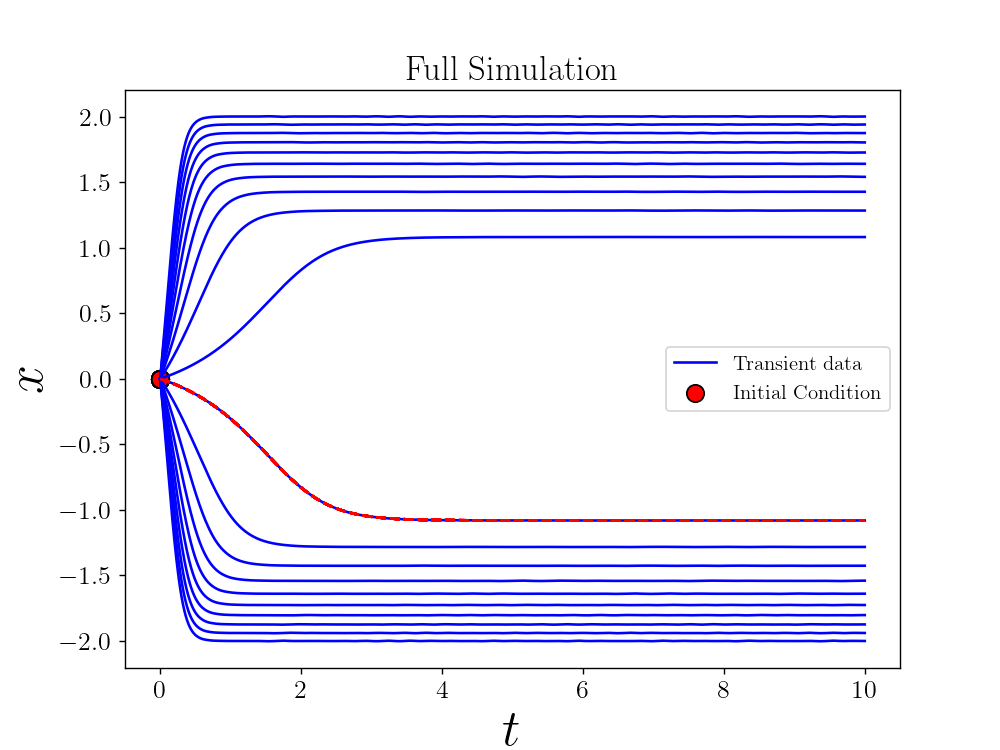

Text(0.5, 1.0, 'Full Simulation')

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(n_ics):
    ax.plot(t, x0[i][:, 0], "b", label='Transient data' if i == 0 else "")
    ax.scatter(t[0], x0[i][0, 0], s=100, edgecolors='black', color='red', label='Initial Condition' if i == 0 else "")
#     ax.scatter(t[-1], pts_eq[i, 0], s=100, edgecolors='black', color='cyan', label='$\mu > 0$' if mu[i]==1 else "")
    ax.plot(few_t, few_X[:, 0], '--r')

ax.set_xlabel("$t$", fontsize=30)
ax.set_ylabel("$x$", fontsize=30)
plt.legend(loc='best', prop={"size":20}, framealpha=1, handletextpad=0.2, handlelength=0.8)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
        
plt.legend(loc='best', prop={"size":12})
plt.title("Full Simulation", fontsize=20)

In [8]:
def musindy(X, t, polyorder, lamb, alpha, dX):
    '''
    Returns a sequential threshholded sparse regression by applying constrained-least-squares regression recursively
    to a pre-normalized candidate library matrix by its maximum value.

    polyorder: Polynomial Order

    '''
    vals, dims = X.shape

    library = PolynomialFeatures(polyorder)
    THETA = library.fit_transform(X)
    variable_names = library.fit(X[:dims, :]).get_feature_names_out(['x', 'y', 'u'][0:dims])

    l = THETA.shape[1]

    # Initialize constraints -------------------------------------------------------------------------
    n_constraints = pts_eq.shape[0] # + ptss.shape[0] 

    C = np.zeros((n_constraints, l))
    d = np.zeros((n_constraints, dims))

    idx = 0  # Index for row of C and element of vector d

#     for p in ptss:         
#         arr = library.fit_transform(np.array([p])).flatten()
#         C[idx, :] = arr
#         d[idx] = ptss_dx[idx, :]
#         idx += 1

    for p in pts_eq:         
        arr = library.fit_transform(np.array([p])).flatten()
        C[idx, :] = arr
        idx += 1

    # -------------------------------------------------------------------------------------------------
    THETA_C = np.r_[THETA, np.sqrt(alpha)*C]
    dX = np.r_[dX, np.sqrt(alpha)*d]

    # -------------------------------------------------------------------------------------------------
    #NORMALIZE COLUMNS
    THETAp = np.zeros_like(THETA_C)
    norms = np.zeros(THETA_C.shape[1])
    for i in range(THETA_C.shape[1]):
        
        norms[i] = np.max(np.abs(THETA_C[:, i]))
        THETAp[:, i] = THETA_C[:, i]/np.max(np.abs(THETA_C[:, i]))
        
    THETA = THETAp
    # -------------------------------------------------------------------------------------------------

    # Initial guess
    CHI = np.linalg.pinv(THETA)@dX

    # Seq. Threshholding
    for k in range(5):
        for i in range(dims):
            lamb2 = np.max(np.abs(CHI[:, i]))*lamb
            smallinds = np.abs(CHI[:, i]) < lamb2
            CHI[smallinds, i] = 0  # Mask
            biginds = smallinds == 0
            CHI[biginds, i] = np.linalg.pinv(THETA[:, biginds])@dX[:, i]

    for i in range(dims):
        CHI[:, i] = CHI[:, i]/norms

    return CHI, variable_names, polyorder

In [9]:
coefw = mysindy2(x0_train, t_train, 0.2, 5, normalize=False)
true_dynamics_5 = coefw[0]
true_dynamics_5

array([[ 0.,  0.],
       [ 1., -0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [-1.,  0.],
       [ 0., -0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [10]:
LAMBDA = 0.15
ALPHA = 1e14

In [11]:
coefw = musindy(few_X, few_t, 5, LAMBDA, ALPHA, deriv4_time(few_X, few_t))
coefw[0]

array([[ 0.   ,  0.   ],
       [ 1.001,  0.   ],
       [ 1.001,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [-1.001,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ]])

## HEATMAP

In [12]:
from numpy.linalg import norm
from numpy.random import normal, permutation, seed

grid_length = 11
seeds = np.arange(0, (grid_length**2)*1000+1, 1)*10

Ec_14_final = []
Ec_1_final = []

Em_14_final = []
Em_1_final = []

rango_ruido = np.linspace(0, 0.01, grid_length)
rango_l = np.linspace(data_amount, data_amount*0.50, grid_length, dtype=int)

signal_power = np.sqrt(np.mean(few_X**2))

seed_idx = 0
for noise in rango_ruido:
    Ec_14_inicial = []
    Ec_1_inicial = []
    
    Em_14_inicial = []
    Em_1_inicial = []

    for largo in rango_l:
        for i in range(500):   # ITERATIONS HERE
            seed(seeds[seed_idx])
            ptss = pts_eq

            '''
            CHOOSE 1 TRANSIENT FOR THE REGRESSION                               ADD NOISE TO THE TRANSIENT HERE
            '''
            eps = noise
            sigma = eps*signal_power

            x_Trans_prior = few_X + np.c_[sigma * normal(size=(few_X.shape[0], 1)), np.zeros(len(few_X))]
            t_Trans_prior = t_train
            dX_prior = deriv4_time(x_Trans_prior, t_Trans_prior)

            '''
            apply algorithm to decimated arrays
            '''
            data_length = largo
            mask = np.sort(permutation(np.arange(x_Trans_prior.shape[0]))[:data_length])

            x_Trans = x_Trans_prior[mask]
            t_Trans = t_Trans_prior[mask]
            dX = dX_prior[mask]

            coeffsw = musindy(x_Trans, t_Trans, 5, LAMBDA, ALPHA, dX)
            coeffs_OG = musindy(x_Trans, t_Trans, 5, LAMBDA, 1, dX)

            # ------------------------------------------------- MODEL ERROR --------------------------------

            Ec_14_inicial.append(norm(coeffsw[0]-true_dynamics_5, ord='fro')/norm(true_dynamics_5, ord='fro'))
            Ec_1_inicial.append(norm(coeffs_OG[0]-true_dynamics_5, ord='fro')/norm(true_dynamics_5, ord='fro'))

            # --------------------------------------------------- SUCCESS RATE ---------------------------------
            sparsity_true = (abs(true_dynamics_5) > 0.001)*1
            sparsity_w = (abs(coeffsw[0]) > 0.001)*1
            sparsity_OG = (abs(coeffs_OG[0]) > 0.001)*1
    
            if norm(sparsity_true - sparsity_w) < 1e-3:
                Em_14_inicial.append(1)
            else:
                Em_14_inicial.append(0)

            if norm(sparsity_true - sparsity_OG) < 1e-3:
                Em_1_inicial.append(1)
            else:
                Em_1_inicial.append(0)

            seed_idx += 1
            

        Em_14_final.append(np.mean(Em_14_inicial))
        Em_1_final.append(np.mean(Em_1_inicial))

        
        Ec_14_final.append(np.mean(Ec_14_inicial))
        Ec_1_final.append(np.mean(Ec_1_inicial))

In [13]:
EC_MUSINDY = np.zeros((len(rango_ruido), len(rango_l)))
EC_OG = np.zeros_like(EC_MUSINDY)

EM_MUSINDY = np.zeros_like(EC_MUSINDY)
EM_OG = np.zeros_like(EC_MUSINDY)


iii = 0
for i in range(len(rango_ruido)):  # noise
    for j in range(len(rango_l)):  # length
        EC_MUSINDY[(len(rango_l)-1)-j, i] = Ec_14_final[iii]
        EC_OG[(len(rango_l)-1)-j, i] = Ec_1_final[iii]
        EM_MUSINDY[(len(rango_l)-1)-j, i] = Em_14_final[iii]
        EM_OG[(len(rango_l)-1)-j, i] = Em_1_final[iii]
        iii += 1

In [14]:
# from scipy.io import savemat, loadmat

# dicc = {'EC_OG': EC_OG,
#         'EC_MUSINDY': EC_MUSINDY,
#         'EM_OG': EM_OG,
#         'EM_MUSINDY': EM_MUSINDY    
#        }

# savemat('heat_data_hysteresis5.mat', dicc)

In [15]:
# from scipy.io import loadmat

# DF = loadmat('heat_data_hysteresis5.mat')
# EC_OG = DF['EC_OG']
# EC_MUSINDY = DF['EC_MUSINDY']
# EM_OG = DF['EM_OG']
# EM_MUSINDY = DF['EM_MUSINDY']

<IPython.core.display.Javascript object>


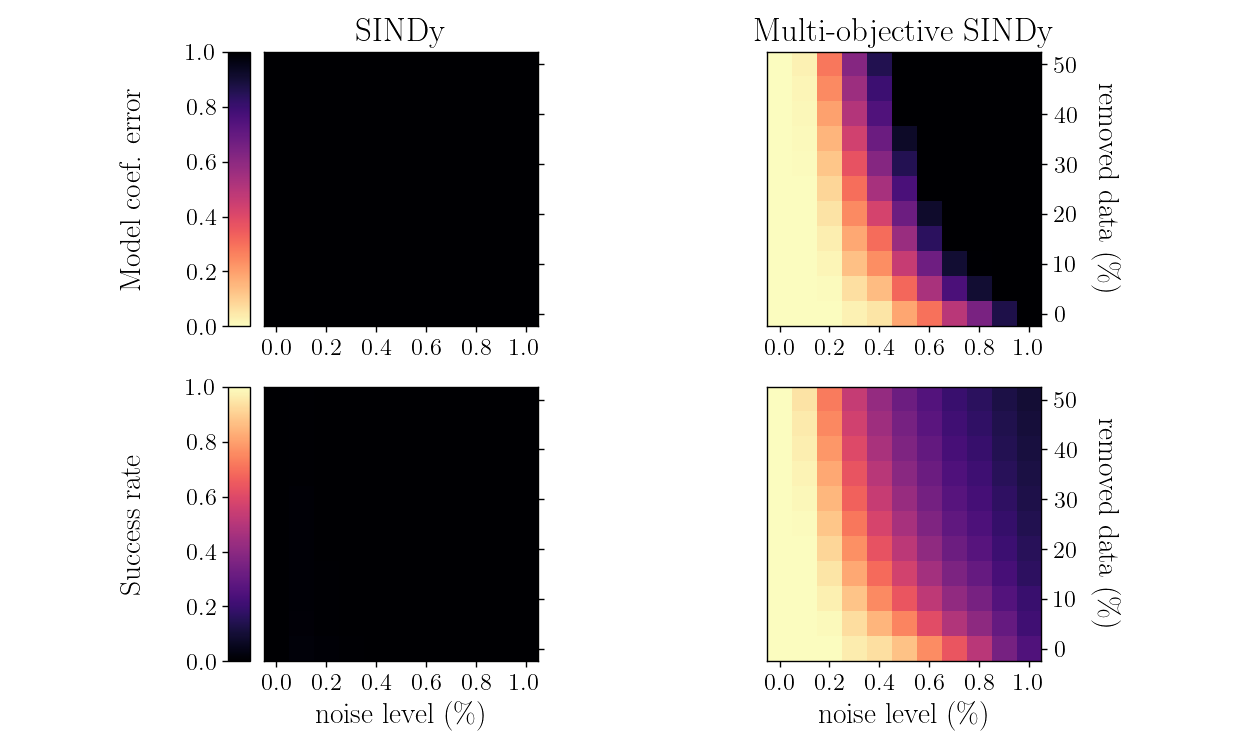

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Crear la figura y las subtramas
fig, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1, 1]})

vmin = 0
vmax = 1

xticks = np.linspace(rango_ruido[0], rango_ruido[-1], 6, endpoint=True) * 100
# xticks_formatted = [f'{x:.2f}' for x in xticks]
yticks = np.linspace((1-rango_l[-1]/rango_l[0])*100, 0, 6, endpoint=True, dtype=int)

FTSIZE = 17
FTSIZE2 = 14

# Gráfico 1
im1 = axs[0, 0].imshow(EC_OG, cmap='magma_r', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('SINDy', fontsize=FTSIZE+2)
axs[0, 0].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 0].set_xticklabels(xticks, fontsize=FTSIZE2)  # Set formatted x-axis tick labels
axs[0, 0].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 0].set_yticklabels(yticks, fontsize=FTSIZE2)
axs[0, 0].tick_params(axis='y', right=True, left=False, labelright=False, labelleft=False)
axs[0, 0].set_ylabel('Success rate', fontsize=FTSIZE, labelpad=20)

# Remove y-label of the leftmost plot
axs[0, 0].set_ylabel('')

axs[0, 1].tick_params(axis='y', right=True, left=False, labelright=True, labelleft=False)

# Gráfico 2
im2 = axs[0, 1].imshow(EC_MUSINDY, cmap='magma_r', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Multi-objective SINDy', fontsize=FTSIZE+2)
axs[0, 1].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 1].set_xticklabels(xticks, fontsize=FTSIZE2)  # Set x-axis tick labels as integers
axs[0, 1].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 1].set_yticklabels(yticks, fontsize=FTSIZE2)
axs[0, 1].set_ylabel('removed data (\%)', fontsize=FTSIZE, rotation=270, labelpad=25)

# -----------------------------------------------------------------------------------------------------------------------

vmin2 = 0
vmax2 = 1

# Gráfico 4
im4 = axs[1, 0].imshow(EM_OG, cmap='magma', vmin=vmin2, vmax=vmax2)
axs[1, 0].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 0].set_xticklabels(xticks, fontsize=FTSIZE2)  # Set x-axis tick labels as integers
axs[1, 0].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 0].set_yticklabels(yticks, fontsize=FTSIZE2)
axs[1, 0].tick_params(axis='y', right=True, left=False, labelright=False, labelleft=False)

# Gráfico 5
im5 = axs[1, 1].imshow(EM_MUSINDY, cmap='magma', vmin=vmin2, vmax=vmax2)
axs[1, 1].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 1].set_xticklabels(xticks, fontsize=FTSIZE2)  # Set x-axis tick labels as integers
axs[1, 1].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 1].set_yticklabels(yticks, fontsize=FTSIZE2)
axs[1, 1].tick_params(axis='y', right=True, left=False, labelright=True, labelleft=False)

axs[1, 1].set_ylabel('removed data (\%)', fontsize=FTSIZE, rotation=270, labelpad=25)

# -----------------------------------------------------------------------------------------------------------------------

# Add x-axis labels to the bottom subplots
axs[1, 0].set_xlabel('noise level (\%)', fontsize=FTSIZE)
axs[1, 1].set_xlabel('noise level (\%)', fontsize=FTSIZE)

# Move y-axis labels to the right of the rightmost plot
axs[0, 1].yaxis.set_label_position("right")
axs[1, 1].yaxis.set_label_position("right")

# Add colorbars to the left of every row
divider1 = make_axes_locatable(axs[0, 0])
cax1 = divider1.append_axes("left", size="8%", pad='5%')
cax1.tick_params(labelsize=FTSIZE2)
cbar1 = plt.colorbar(im2, cax=cax1)
cbar1.set_label('Model coef. error', fontsize=FTSIZE, labelpad=-75, rotation=90)
cbar1.ax.yaxis.set_ticks_position("left")

divider2 = make_axes_locatable(axs[1, 0])
cax2 = divider2.append_axes("left", size="8%", pad='5%')
cax2.tick_params(labelsize=FTSIZE2)
cbar2 = plt.colorbar(im4, cax=cax2)
cbar2.set_label('Success rate', fontsize=FTSIZE, labelpad=-75, rotation=90)
cbar2.ax.yaxis.set_ticks_position("left")

# Ajustar el espaciado entre subtramas
plt.tight_layout()

# Mostrar el gráfico
plt.show()
plt.savefig('hysteresis_heatmap_5th.pdf')

In [17]:
library_test = PolynomialFeatures(5)
theta_tr = library_test.fit_transform(trans(x0_train, data_amount, new_step, len(mu)))
theta_att = library_test.fit_transform(ptss)
theta_tr.shape, theta_att.shape

((20000, 21), (20, 21))

In [18]:
# import scipy.io

# data_SaddleNode = {
#                    'x0': 0,
#                    'Mu': mu,
#                    'mu_tr': few_X[0, -1],
#                    'dt': dt,
#                    'r': [new_step]*20,
#                    'm': [new_step]*20,
#                    'X_tr': trans(x0_train, data_amount, new_step, len(mu)),
#                    'X_att': pts_eq,
#                    'X_dot_tr': deriv4_time(trans(x0_train, data_amount, new_step, len(mu)),
#                                            trans(t_train.reshape(-1, 1), data_amount, new_step, len(mu))),
#                    'X_dot_att': np.c_[np.zeros(len(mu)), mu],
#                    'Theta_tr': theta_tr,
#                    'Theta_att': theta_att,
#                    'theta': coeffsw[1],
#                    'lambda': [LAMBDA],
#                    'alpha_exp': str(ALPHA)
#                   }

# scipy.io.savemat('data_SaddleNode_5th.mat', data_SaddleNode)